<a href="https://colab.research.google.com/github/dnasywa/NutriScan/blob/main/Machine%20Learning/capstone_RGB_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Preparation

## Overview

In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# dataset Info
base_dir = '/content/drive/MyDrive/capstone/dataset/lettuce'
class_names = ['FN', '-N', '-P', '-K']

## Split

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

In [ ]:
train_dir = base_dir + "/train"
validation_dir = base_dir + "/validation"
test_dir = base_dir + "/test"

In [ ]:
# create the directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [ ]:
# define the split ratios
train_ratio = 0.6  # 60% of data for training
validation_ratio = 0.25  # 25% of data for validation
test_ratio = 0.15  # 15% of data for testing

In [ ]:
for class_name in class_names:
    folder_path = os.path.join(base_dir, class_name)

    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)

        # split images into train 0.6 and remaining
        train_images, remaining_images = train_test_split(images, test_size=0.4, random_state=42)

        # split remaining images into validation 0.25 and test 0.15
        validation_images, test_images = train_test_split(remaining_images, test_size=0.375, random_state=42)
            
        # copy TRAIN images to the TRAIN directory
        for image in train_images:
            src = os.path.join(folder_path, image)
            dst = os.path.join(train_dir, class_name, image)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copy2(src, dst)
            
        # copy VALIDATION images to the VALIDATION directory
        for image in validation_images:
            src = os.path.join(folder_path, image)
            dst = os.path.join(validation_dir, class_name, image)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copy2(src, dst)
            
        # copy TEST images to the TEST directory
        for image in test_images:
            src = os.path.join(folder_path, image)
            dst = os.path.join(test_dir, class_name, image)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copy2(src, dst)

## Augmentation

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
img_width, img_height = 224, 224 # Image size to be used

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range = 40,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
    brightness_range = [0.8, 1.2]
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = 32,
    class_mode ='categorical'
)

Found 144 images belonging to 4 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)

Found 60 images belonging to 4 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)

Found 40 images belonging to 4 classes.


# Feature Extraction

In [ ]:
import cv2
import random
import numpy as np

from collections import Counter
from sklearn.cluster import KMeans
from sklearn.feature_extraction import image

%matplotlib inline

## RGB Extraction

In [ ]:
# convert the hex values
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [ ]:
# accept both file paths and numpy array
def get_image(image):
    if isinstance(image, str):  # when image is a file path
        image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [ ]:
def get_colors(image, number_of_colors):

    modified_image = cv2.resize(image, (img_width, img_height), interpolation=cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0] * modified_image.shape[1], 3)

    # warning: default value for n_init will change from 10 to 'auto' in scikit-learn version 1.4
    clf = KMeans(n_clusters=number_of_colors, n_init=10)
    labels = clf.fit_predict(modified_image)

    counts = Counter(labels)
    center_colors = clf.cluster_centers_

    # ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] / 255 for i in counts.keys()]
    rgb_colors = [ordered_colors[i] * 255 for i in counts.keys()]

    return rgb_colors # a list of features

In [ ]:
# check the RGB arrays returns
for i in range(3):
    # select a random folder from TRAIN dataset
    folder = random.choice(os.listdir(train_dir))
    folder_path = os.path.join(train_dir, folder)
    image_files = os.listdir(folder_path)

     # select a random image from the folder
    image_file = random.choice(image_files)
    image_path = os.path.join(folder_path, image_file)

    # return the RGB arrays
    print(image_path)
    print(get_colors(get_image(image_path), 3))

/content/drive/MyDrive/capstone/dataset/lettuce/train/-N/-N (34).png
[array([141.32837015, 171.41149326,  61.9400726 ]), array([249.11911142, 249.57284908, 246.88984485]), array([28.23648888, 33.60315048, 22.709416  ])]
/content/drive/MyDrive/capstone/dataset/lettuce/train/-P/-P (3).png
[array([202.47434305, 222.99428742, 229.4045502 ]), array([81.09101768, 69.29252269, 26.71201624]), array([125.81129238, 116.46379971,  96.6955868 ])]
/content/drive/MyDrive/capstone/dataset/lettuce/train/-P/-P (49).png
[array([36.13802586, 54.49394418, 61.03101047]), array([188.06835577, 234.61710214, 141.30673001]), array([139.83649222, 181.08755304,  98.12758133])]


## Extract from Directories

In [ ]:
# lists and array to store the features and labels
train_features = []
train_labels = np.empty((0,), dtype=str)

validation_features = []
validation_labels = np.empty((0,), dtype=str)

test_features = []
test_labels = np.empty((0,), dtype=str)

In [ ]:
# iterate over the TRAIN directory
for folder_name in os.listdir(train_dir):
    folder_path = os.path.join(train_dir, folder_name)
    
    # extract if the item is a directory
    if os.path.isdir(folder_path):
        # iterate over the files in the current dir
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            
            # check if the item is a file
            if os.path.isfile(file_path):
                # extract features from the image
                image = get_image(file_path)
                preprocessed_image = train_datagen.random_transform(image)
                features = get_colors(preprocessed_image, 3)

                # append the features to the train_features list
                train_features.append(features)
                train_labels = np.concatenate((train_labels, np.array([folder_name])), axis=0)

In [ ]:
# convert to a numpy array
train_features = np.array(train_features)

In [ ]:
# print the shape of the TRAIN arrays
print("Train Features Shape:", train_features.shape)
print("Train Labels Shape:", train_labels.shape)

Train Features Shape: (144, 3, 3)
Train Labels Shape: (144,)


In [ ]:
# iterate over the VALIDATION directory
for folder_name in os.listdir(validation_dir):
    folder_path = os.path.join(validation_dir, folder_name)
    
    # check if the item is a directory
    if os.path.isdir(folder_path):
        # iterate over the files in the current dir
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            
            # check if the item is a file
            if os.path.isfile(file_path):
                # extract features from the image
                image = get_image(file_path)
                preprocessed_image = validation_datagen.random_transform(image)
                features = get_colors(preprocessed_image, 3)

                # append the features to the validation_features list
                validation_features.append(features)
                validation_labels = np.concatenate((validation_labels, np.array([folder_name])), axis=0)

In [ ]:
# convert to a numpy array
validation_features = np.array(validation_features)

In [ ]:
# print the shape of the VALIDATION arrays
print("Validation Features Shape:", validation_features.shape)
print("Validation Labels Shape:", validation_labels.shape)

Validation Features Shape: (60, 3, 3)
Validation Labels Shape: (60,)


In [ ]:
# iterate over the TEST directory
for folder_name in os.listdir(test_dir):
    folder_path = os.path.join(test_dir, folder_name)
    
    # check if the item is a directory
    if os.path.isdir(folder_path):
        # iterate over the files in the current dir
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            
            # check if the item is a file
            if os.path.isfile(file_path):
                # extract features from the image
                image = get_image(file_path)
                preprocessed_image = test_datagen.random_transform(image)
                features = get_colors(preprocessed_image, 3)

                # append the features to the test_features list
                test_features.append(features)
                test_labels = np.concatenate((test_labels, np.array([folder_name])), axis=0)

In [ ]:
# convert to a numpy array
test_features = np.array(test_features)

In [ ]:
# print the shape of the TEST arrays
print("Test Features Shape:", test_features.shape)
print("Test Labels Shape:", test_labels.shape)

Test Features Shape: (40, 3, 3)
Test Labels Shape: (40,)


# Model

## RGB Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
model = tf.keras.Sequential([
    layers.Conv1D(32, 1, activation='relu', input_shape=(3, 3)),
    layers.Conv1D(64, 1, activation='relu'),
    layers.Conv1D(128, 1, activation='relu'),
    
    layers.LSTM(32, return_sequences=True),
    layers.LSTM(64),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    
    layers.Dropout(0.5),
    
    layers.Dense(4, activation='softmax')
])

In [ ]:
optimizer = tf.keras.optimizers.RMSprop()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_33 (Conv1D)          (None, 3, 32)             128       
                                                                 
 conv1d_34 (Conv1D)          (None, 3, 64)             2112      
                                                                 
 conv1d_35 (Conv1D)          (None, 3, 128)            8320      
                                                                 
 lstm_22 (LSTM)              (None, 3, 32)             20608     
                                                                 
 lstm_23 (LSTM)              (None, 64)                24832     
                                                                 
 flatten_11 (Flatten)        (None, 64)                0         
                                                                 
 dense_44 (Dense)            (None, 64)              

## Model Training

In [ ]:
import numpy as np
import tensorflow as tf

from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
label_mapping = {"FN": 0, "-N": 1, "-P": 2, "-K": 3}

In [ ]:
# map string labels to integer values
train_labels_mapped = np.array([label_mapping[label] for label in train_labels])
validation_labels_mapped = np.array([label_mapping[label] for label in validation_labels])
test_labels_mapped = np.array([label_mapping[label] for label in test_labels])

# one-hot encode the mapped labels
train_labels_one_hot = to_categorical(train_labels_mapped)
validation_labels_one_hot = to_categorical(validation_labels_mapped)
test_labels_one_hot = to_categorical(test_labels_mapped)

In [ ]:
# define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_features,
    train_labels_one_hot,
    epochs=400,
    batch_size=64,
    validation_data=(validation_features, validation_labels_one_hot),
    callbacks=[early_stopping]
)

Epoch 1/400
3/3 [==============================] - 7s 577ms/step - loss: 1.3823 - accuracy: 0.2708 - val_loss: 1.3832 - val_accuracy: 0.2667
Epoch 2/400
3/3 [==============================] - 0s 27ms/step - loss: 1.3813 - accuracy: 0.2986 - val_loss: 1.3756 - val_accuracy: 0.2833
Epoch 3/400
3/3 [==============================] - 0s 28ms/step - loss: 1.3702 - accuracy: 0.2569 - val_loss: 1.3667 - val_accuracy: 0.4333
Epoch 4/400
3/3 [==============================] - 0s 36ms/step - loss: 1.3647 - accuracy: 0.3611 - val_loss: 1.3737 - val_accuracy: 0.2500
Epoch 5/400
3/3 [==============================] - 0s 34ms/step - loss: 1.3745 - accuracy: 0.3056 - val_loss: 1.3543 - val_accuracy: 0.4167
Epoch 6/400
3/3 [==============================] - 0s 29ms/step - loss: 1.3435 - accuracy: 0.3194 - val_loss: 1.3238 - val_accuracy: 0.6000
Epoch 7/400
3/3 [==============================] - 0s 27ms/step - loss: 1.2982 - accuracy: 0.4375 - val_loss: 1.3475 - val_accuracy: 0.2833
Epoch 8/400
3/3 [==

In [ ]:
loss, accuracy = model.evaluate(test_features, test_labels_one_hot)
print("Loss:", loss)
print("Accuracy:", accuracy)

2/2 [==============================] - 0s 8ms/step - loss: 0.6866 - accuracy: 0.7500
Loss: 0.6866004467010498
Accuracy: 0.75


## Evaluation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# convert predicted probabilities to labels
y_pred_probs = model.predict(test_features)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

2/2 [==============================] - 1s 6ms/step


In [ ]:
# convert test_labels to numeric labels
numeric_labels = np.array([label_mapping[label] for label in test_labels])

In [ ]:
# calculate confusion matrix
confusion = confusion_matrix(numeric_labels, y_pred_labels)

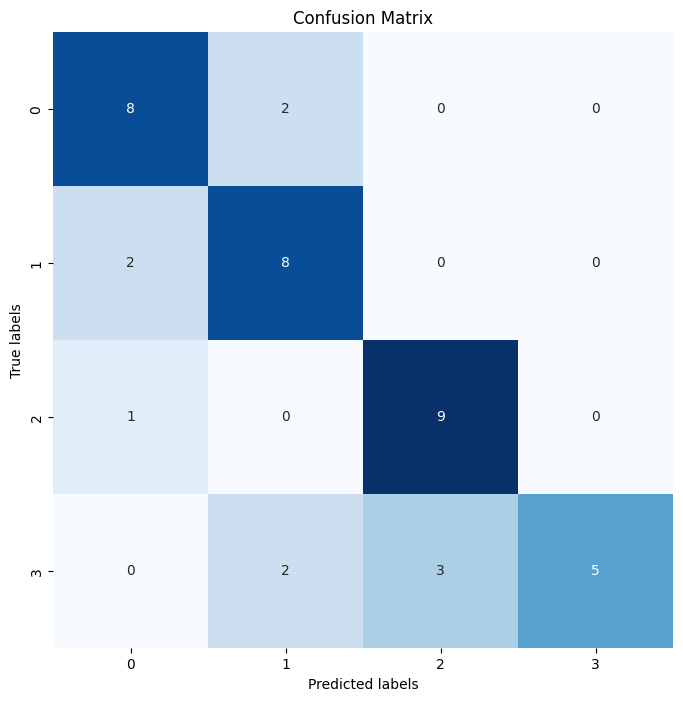

In [ ]:
# visualize the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# generate classification report
report = classification_report(numeric_labels, y_pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.67      0.80      0.73        10
           2       0.75      0.90      0.82        10
           3       1.00      0.50      0.67        10

    accuracy                           0.75        40
   macro avg       0.79      0.75      0.74        40
weighted avg       0.79      0.75      0.74        40



In [ ]:
def plot_training_history(history):
    # get the training and validation metrics
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(accuracy, 'g', label='Training Accuracy')
    plt.plot(val_accuracy, 'b', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

    # plot loss
    plt.figure(figsize=(6, 4))
    plt.plot(loss, 'g', label='Training Loss')
    plt.plot(val_loss, 'b', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

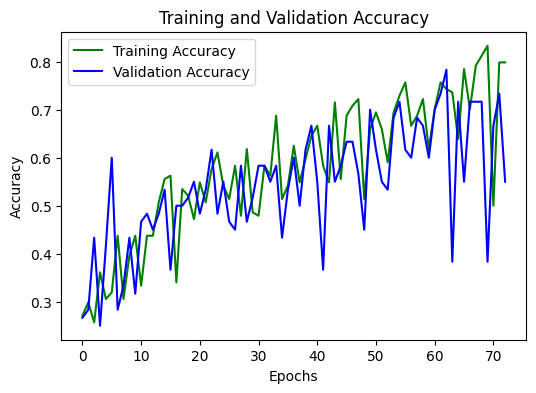

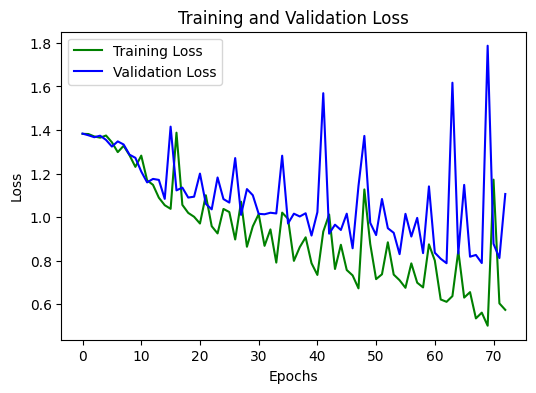

In [ ]:
plot_training_history(history)

# Predict and Recommendation

## Make a Prediction

In [ ]:
from PIL import Image

In [ ]:
def get_input(image_path):
    image = get_image(image_path)
    image = get_colors(image, 3)
    image = np.expand_dims(image, axis=0)  # an extra dimension for batch size
    return image

In [ ]:
input_image = get_input('/content/drive/MyDrive/capstone/dataset/lettuce/-P/-P (37).png') # CONTOH GAMBAR YANG AKAN DIPREDIKSI

In [ ]:
# predict the label
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions)
predicted_label = class_names[predicted_class]
print(predicted_label)

1/1 [==============================] - 0s 32ms/step
-P


In [ ]:
label_mapping = {"FN": "Nutrisi Cukup", "-N": "Kekurangan Nitrogen", "-P": "Kekurangan Fosfor", "-K": "Kekurangan Kalium"}

In [ ]:
output_labels_mapped = label_mapping[predicted_label]
print(output_labels_mapped)

## Give the Recommendation

In [ ]:
def generate_custom_paragraph(predicted_label):
    # Define a mapping of labels to custom paragraphs
    mapping = { # tinggal revisi paragraf
        'FN': 'Seladamu terindikasi sehat',
        '-N': 'Seladamu terindikasi kekurangan nitrogen',
        '-P': 'Seladamu terindikasi kekurangan fosfor',
        '-K': 'Seladamu terindikasi kekurangan kalium',
    }
    
    # Get the custom paragraph based on the predicted label
    custom_paragraph = mapping.get(predicted_label, 'Tidak ada rekomendasi untuk saat ini')
    
    return custom_paragraph

In [ ]:
generate_custom_paragraph(predicted_label)

'Seladamu terindikasi kekurangan fosfor'

# Keras Model .h5

In [ ]:
import tensorflow as tf

In [ ]:
model.save(base_dir + 'lettuce_model.h5')
model = tf.keras.models.load_model(base_dir + 'lettuce_model.h5')

In [ ]:
export_dir = 'saved_model_capstone'
tf.saved_model.save(model, export_dir=export_dir)

In [ ]:
mode = "" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [ ]:
# convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [optimization]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

# disable experimental lowering of tensor list ops
converter.experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

In [ ]:
# save the TensorFlow Lite model
with open('lettuce_model.tflite', 'wb') as f:
    f.write(tflite_model)